# RiskDAG Quickstart

This notebook demonstrates the core features of RiskDAG in 5 minutes.

## 1. Import and Setup

In [11]:
from riskdag import RiskDAG, RiskNode, LatentRiskNode
from riskdag.visualization import visualize_risk_dag, create_interactive_dashboard
from scipy import stats

print("RiskDAG imported successfully!")

✓ RiskDAG imported successfully!


## 2. Create a Simple Pipeline

Using the ultra-simple pattern with context manager:

In [12]:
with RiskDAG('etl_pipeline', time_scale='hour') as dag:
    # Infrastructure risks
    cloud = LatentRiskNode(
        'cloud',
        p_fail=0.01,  # 1% daily probability
        loss_dist=stats.norm(loc=5000, scale=1000),
        user_time_scale='day'
    )
    
    database = LatentRiskNode(
        'database',
        p_fail=0.02,  # 2% daily probability
        loss_dist=stats.norm(loc=10000, scale=2000),
        user_time_scale='day'
    )
    
    # Tasks
    extract = RiskNode('extract', p_fail=0.01, loss_dist=stats.norm(500, 100))
    transform = RiskNode('transform', p_fail=0.05, loss_dist=stats.norm(1000, 200))
    load = RiskNode('load', p_fail=0.02, loss_dist=stats.norm(800, 150))
    
    # Contagion: cloud service failure → 60% chance database fails
    cloud @ database | 0.6
    
    # Cascade: Database down → extract ALWAYS fails
    database >> extract
    
    # Task flow
    extract >> transform >> load

print(f"Created: {dag}")
print(f"Total nodes: {len(dag.nodes)}")
print(f"Latent risks: {len(dag.latent_risks)}")

Created: RiskDAG('etl_pipeline', nodes=5, latent=2)
Total nodes: 5
Latent risks: 2


## 3. Visualize the DAG

See the graph with tasks above and latent risks below:

In [13]:
widget = visualize_risk_dag(dag)
widget

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'LR', 'nodeSep': 50, 'rankSep': 100, 'animate': …

## 4. Run Monte Carlo Simulation

In [14]:
# Run 1000 simulations
results = dag.run_monte_carlo(n_simulations=1000, seed=42)

print("Simulation complete!")

Simulation complete!


## 5. Analyze Results

In [15]:
# Get summary statistics
stats_summary = results.summary_statistics()

print("Risk Metrics:")
print(f"  Mean Loss:     ${stats_summary['mean_loss']:,.2f}")
print(f"  95% VaR:       ${stats_summary['var_95']:,.2f}")
print(f"  99% VaR:       ${stats_summary['var_99']:,.2f}")
print(f"  95% ES:        ${stats_summary['es_95']:,.2f}")
print(f"  99% ES:        ${stats_summary['es_99']:,.2f}")

Risk Metrics:
  Mean Loss:     $127.17
  95% VaR:       $1,461.44
  99% VaR:       $2,256.10
  95% ES:        $2,174.40
  99% ES:        $3,431.74


## 6. Node Failure Rates

In [16]:
print("Task Failure Rates (including latent risk impact):")
for node_id in ['extract', 'transform', 'load']:
    rate = results.node_failure_rate(node_id)
    print(f"  {node_id:15s} {rate:6.2%}")

print("\nLatent Risk Trigger Rates:")
for node_id in ['cloud', 'database']:
    rate = results.node_failure_rate(node_id)
    print(f"  {node_id:15s} {rate:6.2%}")

Task Failure Rates (including latent risk impact):
  extract          1.10%
  transform        5.40%
  load             7.00%

Latent Risk Trigger Rates:
  cloud            0.00%
  database         0.10%


## 7. Visualize Results - Exceedance Curve

In [17]:
dashboard = create_interactive_dashboard(dag, results, es_percentile=0.95)
widget = dashboard.create_dashboard()
widget

## 8. Visualize Results - Loss Distribution

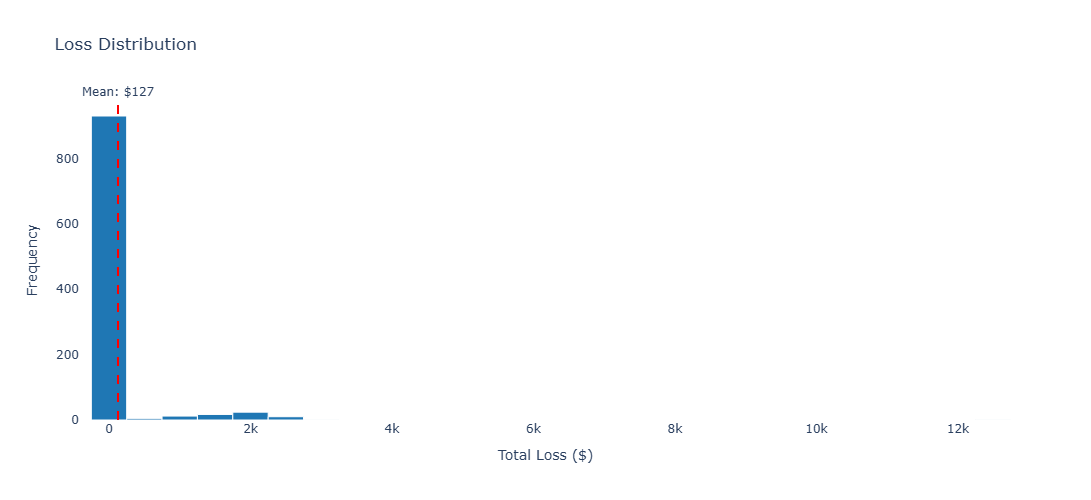

In [18]:
from riskdag import plot_loss_distribution

fig = plot_loss_distribution(results)
fig.show()

## 9. Compare: Deterministic (`>>`) vs Probabilistic (`@`)

In [19]:
# Scenario 1: Deterministic cascade
with RiskDAG('deterministic', time_scale='hour') as dag1:
    db = LatentRiskNode('database', p_fail=0.02, 
                        loss_dist=stats.norm(10000, 2000),
                        user_time_scale='day')
    task = RiskNode('task', p_fail=0.01, loss_dist=stats.norm(500, 100))
    
    db >> task  # Deterministic: DB fails → task ALWAYS fails

results1 = dag1.run_monte_carlo(10000, seed=42)

# Scenario 2: Probabilistic contagion
with RiskDAG('probabilistic', time_scale='hour') as dag2:
    network = LatentRiskNode('network', p_fail=0.015,
                             loss_dist=stats.norm(5000, 1000),
                             user_time_scale='day')
    task = RiskNode('task', p_fail=0.01, loss_dist=stats.norm(500, 100))
    
    network @ task | 0.7  # Probabilistic: Network fails → task has 70% chance of failing

results2 = dag2.run_monte_carlo(10000, seed=42)

print("Comparison:")
print(f"\nDeterministic (>>):")
print(f"  Database trigger:  {results1.node_failure_rate('database'):.2%}")
print(f"  Task failure:      {results1.node_failure_rate('task'):.2%}")
print(f"\nProbabilistic (@):")
print(f"  Network trigger:   {results2.node_failure_rate('network'):.2%}")
print(f"  Task failure:      {results2.node_failure_rate('task'):.2%}")
print(f"\nNote: With >>, task always fails when latent triggers.")
print(f"      With @, task only fails 70% of the time when latent triggers.")

Comparison:

Deterministic (>>):
  Database trigger:  0.10%
  Task failure:      1.25%

Probabilistic (@):
  Network trigger:   0.05%
  Task failure:      1.13%

Note: With >>, task always fails when latent triggers.
      With @, task only fails 70% of the time when latent triggers.
